In [2]:
!pip install arch

  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/d3/e7/e2d21cd3374abfffeae80e23fb164ba35515e2b63a5d1a545a23f71ac343/arch-6.2.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/922.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/922.8 kB ? eta -:--:--
   - ------------------------------------- 41.0/922.8 kB 991.0 kB/s eta 0:00:01
   -------- ------------------------------- 194.6/922.8 kB 3.0 MB/s eta 0:00:01
   ------------------------ --------------- 573.4/922.8 kB 4.5 MB/s eta 0:00:01
   ---------------------------------------  921.6/922.8 kB 5.8 MB/s eta 0:00:01
   ---------------------------------------  921.6/922.8 kB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 922.8/922.8 kB 4.2 MB/s eta 0:00:00


# 1. Modeling Volatility and VaR

In [6]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
import warnings
warnings.filterwarnings('ignore')
# import_path = os.getcwd() + '/finm-portfolio-2023'


rets = pd.read_excel(r'../data/barnstable_analysis_data.xlsx', sheet_name=1)
rets.set_index('date', inplace=True)
rets.fillna(method='ffill', inplace=True)
rets['Excess SPY Returns'] = rets['SPX'] - rets['TB1M'] 
rets.head()


,SPX,TB1M,Excess SPY Returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033296,0.002612,-0.035908
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


## 1. Historic VaR

### Plotting VaR over time
We can see that the expanding VaR becomes less and less sensitive to new data as the pool of data points gets larger and larger.

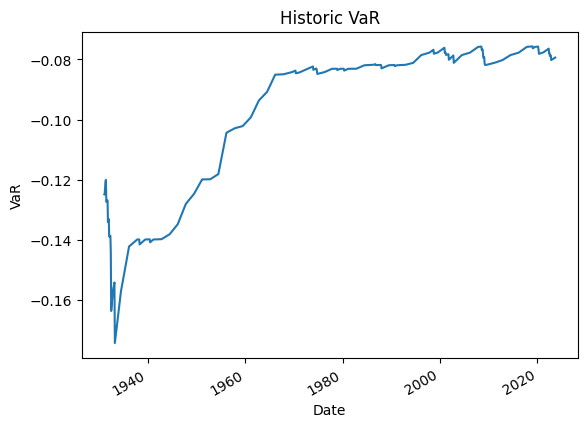

5% VaR backtest: 3.15%


In [22]:
historic_VaR = rets['Excess SPY Returns'].shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot()


plt.title('Historic VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

exceed = sum(rets['Excess SPY Returns'] < historic_VaR)/len(historic_VaR.dropna())
print('5% VaR backtest: {:,.2%}'.format(exceed))

## 2. Volatility

### a. Volatility Plots

The Expanding window VaR looks like it tends to just converge since new data points hold less and less weight. The Rolling window however, seems to do a better job of reflecting more recent changes in volatility.

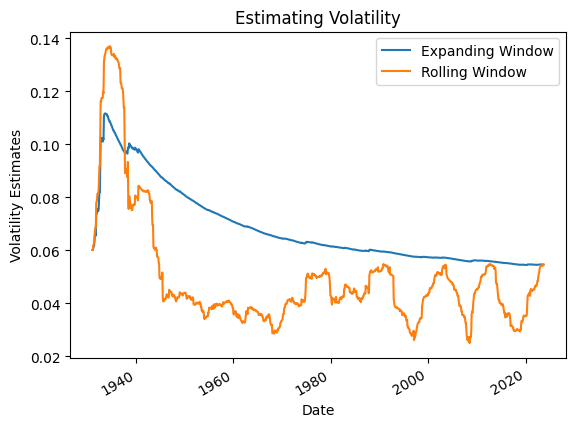

In [23]:
stdev = np.sqrt((rets['Excess SPY Returns']**2).shift(1).expanding(60).mean().to_frame('Expanding Window'))
stdev['Rolling Window'] = np.sqrt((rets['Excess SPY Returns']**2).shift(1).rolling(60).mean())
stdev.plot()
plt.title('Estimating Volatility')
plt.ylabel('Volatility Estimates')
plt.xlabel('Date')
plt.show()

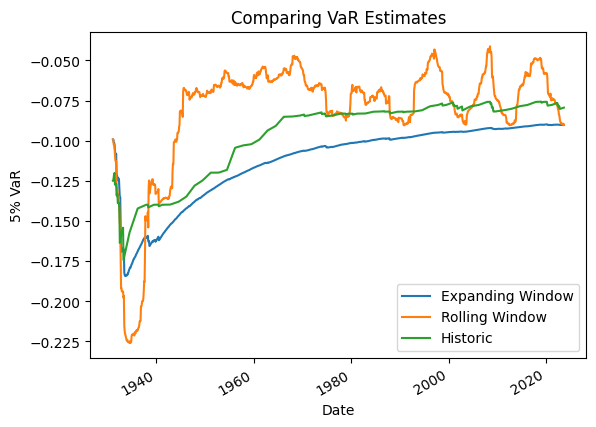

In [25]:
VaR = -1.65*stdev
VaR['Historic'] = historic_VaR

VaR.plot()
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.show()

### c. VaR Predictions across Different Windows

In [11]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[rets.loc[VaR.index, 'Excess SPY Returns'] < VaR[col]]) / len(VaR[col].dropna().index)
    
display(freq_df.style.format('{:,.2%}'))

,Expanding Window,Rolling Window,Historic
Frequency,1.80%,4.95%,3.15%


## 3. CVaR

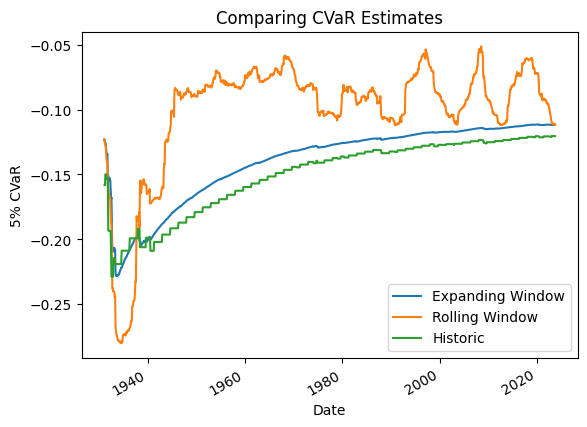

In [26]:
historic_CVaR = []

for i in range(len(rets)):
    if i < 61:
        historic_CVaR.append(np.nan)
    else:
        window = rets[['Excess SPY Returns']][:i-1]
        CVaR = window[window < window.quantile(0.05)]['Excess SPY Returns'].mean()
        historic_CVaR.append(CVaR)

scaling_for_vol = norm.pdf(1.65)/0.05 #trucated normal

CVaR = -scaling_for_vol * stdev

CVaR['Historic'] = historic_CVaR

CVaR.plot()
plt.title('Comparing CVaR Estimates')
plt.ylabel('5% CVaR')
plt.xlabel('Date')
plt.show()

In [27]:
GARCH = arch_model(rets['Excess SPY Returns'], vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit()
GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 47894645.18374588
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1950.463412480511
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1950.4634158658437
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          0.007870
omega       0.000059
alpha[1]    0.100000
beta[1]     0.879999
Name: params, dtype: float64

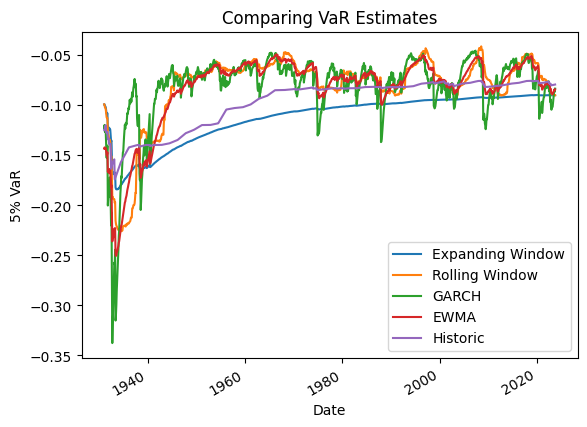

,Expanding Window,Rolling Window,GARCH,EWMA,Historic
Frequency,1.80%,4.95%,4.59%,4.32%,3.15%


In [28]:
stdev[['GARCH','EWMA']] = None

### Initialize with the given parameter
stdev.iloc[0,2:] = 0.15
theta = 0.97

### Simulate the rest of the period using the initial variance given
for i in range(1, len(stdev)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    stdev['EWMA'].iloc[i] = np.sqrt((stdev['EWMA'].iloc[i-1]**2) * theta + (1-theta)*(rets[['Excess SPY Returns']].iloc[i-1,0]**2))
    stdev['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega'] + (stdev['GARCH'].iloc[i-1]**2) * GARCH_model.params['beta[1]'] + GARCH_model.params['alpha[1]']*(rets[['Excess SPY Returns']].iloc[i-1,0]**2))
    
stdev.dropna(inplace=True)

VaR = -1.65*stdev
VaR['Historic'] = historic_VaR

VaR.plot()
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.show()

freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[rets.loc[VaR.index, 'Excess SPY Returns'] < VaR[col]]) / len(VaR[col].dropna().index)
    
display(freq_df.style.format('{:,.2%}'))

# 3. Estimating Underperformance

In [29]:
rets = pd.read_excel(r'../data/barnstable_analysis_data.xlsx', sheet_name=1)
rets.set_index('date', inplace=True)
rets.fillna(method='ffill', inplace=True)
rets['Excess SPY Returns'] = rets['SPX'] - rets['TB1M'] 
rets.head()


,SPX,TB1M,Excess SPY Returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033296,0.002612,-0.035908
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


In [41]:
stats_table = pd.DataFrame(
            index = pd.MultiIndex.from_tuples([('levels', 'SPX'),('levels', 'RiskFree'),('levels', 'Excess SPX'),
                                              ('logs', 'SPX'),('logs', 'RiskFree'), ('logs', 'Excess SPX')]),
            columns = pd.MultiIndex.from_tuples([('1965-1999','mean'),('1965-1999','vol'),
                                                ('2000-2022','mean'),('2000-2022','vol'),
                                                ('1926-2022','mean'),('1926-2022','vol')]))
# list(rets.loc['1965':'1999'].mean())
stats_table[('1965-1999','mean')] = list(rets.loc['1965':'1999'].mean() * 12) + list(np.log(1+rets.loc['1965':'1999']).mean() * 12)
stats_table[('1965-1999','vol')] = list(np.std(rets.loc['1965':'1999']) * np.sqrt(12)) + list(np.std(np.log(1+rets.loc['1965':'1999'])) * np.sqrt(12))
stats_table[('2000-2022','mean')] = list(rets.loc['2000':'2022'].mean() * 12) + list(np.log(1+rets.loc['2000':'2022']).mean() * 12)
stats_table[('2000-2022','vol')] = list(np.std(rets.loc['2000':'2022']) * np.sqrt(12)) + list(np.std(np.log(1+rets.loc['2000':'2022'])) * np.sqrt(12))
stats_table[('1926-2022','mean')] = list(rets.mean() * 12) + list(np.log(1+rets).mean() * 12)
stats_table[('1926-2022','vol')] = list(np.std(rets) * np.sqrt(12)) + list(np.std(np.log(1+rets)) * np.sqrt(12))

display(stats_table.style.format('{:,.2%}'))

### b.

We can see that the period between 1965-1999 is very different than from 2000-2022. The SPX returns did stay relatively the same but if you take a look at the excess return and the risk free rate, they are very different between the two periods, especially the risk free rate.

## 2. 

In [42]:
def prob(mu, sigma, h):
    return norm.cdf(-np.sqrt(h)*mu/sigma)

mu = stats_table[('1965-1999', 'mean')][('logs', 'Excess SPX')]
sigma = stats_table[('1965-1999', 'vol')][('logs', 'Excess SPX')]

print('Probability of SPX underperforming RF in the next 15 years after 1999: {:,.2%}'.
      format(prob(mu = mu, sigma = sigma, h = 15)))

print('Probability of SPX underperforming RF in the next 30 years after 1999: {:,.2%}'.
      format(prob(mu = mu, sigma = sigma, h = 30)))

Probability of SPX underperforming RF in the next 15 years after 1999: 7.39%
Probability of SPX underperforming RF in the next 30 years after 1999: 2.03%
